In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import os.path
from loguru import logger
import seaborn as sns
import plotly.graph_objects as go
import datetime
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from scipy.optimize import least_squares


## Preloaded data

In [2]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv", nrows = 30_000_000)


In [3]:
df.head()

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,12888.0,0.0145,0.0140,309.0,68.60,0.0150,230.0,70.70,0.0146,69.75,ETH-9DEC22,1294.5900,0.24508,0.00230,0.61504,-2.57385,0.06814
1,deribit,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,185.0,0.0640,0.0630,127.0,74.35,0.0650,214.0,76.80,0.0632,74.51,SYN.ETH-16DEC22,1294.5233,-0.48057,0.00202,1.05725,-2.56887,-0.29568
2,deribit,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,7503.0,0.0150,0.0135,426.0,72.46,0.0145,219.0,74.30,0.0140,73.44,SYN.ETH-16DEC22,1294.5233,0.18313,0.00136,0.70376,-1.68530,0.09196
3,deribit,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,11013.0,0.1275,0.1310,101.0,71.44,0.1335,83.0,73.73,0.1325,72.78,ETH-30DEC22,1294.2700,-0.60928,0.00144,1.40850,-1.74735,-0.77151
4,deribit,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,26858.0,0.0145,0.0140,32.0,66.44,0.0150,85.0,70.60,0.0147,69.18,ETH-2DEC22,1294.4500,0.46756,0.00735,0.31108,-8.07055,0.02142


In [4]:
def select_data(df: pd.DataFrame, currency: str  = "BTC"):
    # take single currency
    ind = [symbol.startswith(currency) for symbol in df.underlying_index]
    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
    
    data = df[ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

    #tau is time before expiration in years
    data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    data['days'] = (data['tau'] * 365).astype(int)
    
    data["human_expiration"] = data["expiration"]\
    .apply(lambda x : datetime.datetime.fromtimestamp(x/1000000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))

    K = data.strike_price.values
    F = data.underlying_price.values

    payoff = np.maximum( F - K, 0.0 )
    payoff[data.type == 'put'] = np.maximum( K - F, 0.0)[data.type == 'put']
    data["payoff"] = payoff
    data['mid_price'] = 0.5 * (data.ask_price + data.bid_price)
    
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)

    put = data_grouped[data_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)

    call = data_grouped[data_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    
    return put, call

In [54]:
put, call = select_data(df, currency="ETH")


Text(0.5, 0, 'strike, $')

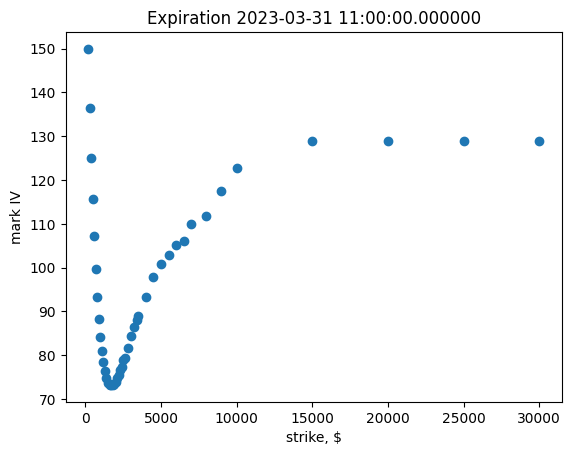

In [55]:
single_expiration_date =  call.sample(1).human_expiration.iloc[0]
call_single_exp = call[call["human_expiration"] == single_expiration_date]
put_single_exp = put[put["human_expiration"] == single_expiration_date]

plt.scatter(call_single_exp["strike_price"], call_single_exp["mark_iv"])
plt.title(f"Expiration {single_expiration_date}")
plt.ylabel("mark IV")
plt.xlabel("strike, $")


In [56]:
days = sorted(list(set(call.days.values)))
print(f"Expiration dates: {days}") 

Expiration dates: [0, 7, 21, 28, 56, 119, 210, 301]


# Калибровка

In [60]:
class SABR:
    def __init__(self, data: pd.DataFrame) -> None:
        """Class to model the volatility smile"""
        self.data = data
        # let it be fixed as in the artice
        self.beta = 0.5
        self.T = data.iloc[0].tau
        #Change by milliseconds, but we need similar
        self.underlying_price = data.iloc[0].underlying_price
        # start params for optimization
        self.x0 = np.array([0.99, 0.00, 0.99])
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]


    def _sigmaB(
        self, f: float, K: float, T: float, alpha: float, rho: float, v: float
    ) -> float:
        """Function to count modeled volatility"""
        first_part_of_numerator = (
            (1 - self.beta) ** 2 / 24 * alpha**2 / (f * K) ** (1 - self.beta)
        )
        second_part_of_numerator = (
            (rho * self.beta * v * alpha) / 4 * (f * K) ** ((1 - self.beta) / 2)
        )
        third_part_of_numerator = (2 - 3 * rho**2) * v**2 / 24
        numerator = alpha * (
            1
            + self.T
            * (
                first_part_of_numerator
                + second_part_of_numerator
                + third_part_of_numerator
            )
        )

        first_part_of_denominator = (1 - self.beta) ** 2 / 24 * (np.log(f / K)) ** 2
        second_part_of_denominator = (1 - self.beta) ** 4 / 1920 * (np.log(f / K)) ** 4
        denominator = (f * K) ** ((1 - self.beta) / 2) * (
            1 + first_part_of_denominator + second_part_of_denominator
        )

        z = v / alpha * (f * K) ** ((1 - self.beta) / 2) * np.log(f / K)

        xi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

        return numerator / denominator * z / xi

    def _plot_results(self) -> None:
        """Function to plot results"""

        def get_sigmas_for_set_of_params(alpha: float, rho: float, v: float) -> None:
            """Inner function to count sigmas for current optimization method"""
            self.volatilities = []
            self.test_strikes = np.linspace(500, 5000, 100)
            for strike in self.test_strikes:
                sigma_modeled = self._sigmaB(
                    self.underlying_price, strike, self.T, alpha, rho, v
                )
                self.volatilities.append(sigma_modeled)

        get_sigmas_for_set_of_params(
            self.alpha_scipy, self.rho_scipy, self.v_scipy
        )

        fig, ax = plt.subplots(figsize=(15, 7))
        ax = sns.scatterplot(x = "strike_price", y = "mark_iv", data=self.data, 
                             color = "black",
                             label="scipy optimizer")

        ax1 = sns.lineplot(
            x=self.test_strikes,
            y=self.volatilities,
            label="market volatilities",
            color="blue",
        ).set_title(f"T = {int(self.T * 365)} days")

    def _vol_square_error(self, x: np.ndarray) -> np.float64:
        """Function to get the argmin function we want to optimize"""
        # init market volatiliteis
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(
                self._sigmaB(
                    self.underlying_price, row["strike_price"], self.T, x[0], x[1], x[2]
                )
            )
        return sum((vols - smile) ** 2)


    def _minimize_scipy(self) -> np.float64:
        """Optimization with scipy optimizer"""
        return minimize(self._vol_square_error, x0=self.x0,  bounds = self.bounds)

    def run(self) -> None:
        """Run optimization and plot results"""
        # optimization via scipy
        optimum_scipy = self._minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        logger.info(
            f"Optimal params for T = {int(self.T*365)} days: alpha = {self.alpha_scipy}, rho = {self.rho_scipy}, v = {self.v_scipy}"
        )
        # plot market values and modeled function
        self._plot_results()
        return self.volatilities


2022-12-08 23:30:47.098 | INFO     | __main__:run:100 - Optimal params for T = 0 days: alpha = 1000.0, rho = -0.00040336526611584115, v = 186.31796318599172
2022-12-08 23:30:47.192 | INFO     | __main__:run:100 - Optimal params for T = 7 days: alpha = 44.64324174884218, rho = -0.002668853036001271, v = 91.8862462345882
2022-12-08 23:30:47.771 | INFO     | __main__:run:100 - Optimal params for T = 21 days: alpha = 317.5374748553489, rho = 0.09154967871063785, v = 2.341219784605344
2022-12-08 23:30:47.921 | INFO     | __main__:run:100 - Optimal params for T = 28 days: alpha = 20.369951066280453, rho = -0.013468267511041201, v = 55.33462479709667
2022-12-08 23:30:48.237 | INFO     | __main__:run:100 - Optimal params for T = 56 days: alpha = 321.1216905953168, rho = -0.00040287882394509316, v = 27.181986705608495
2022-12-08 23:30:48.547 | INFO     | __main__:run:100 - Optimal params for T = 119 days: alpha = 315.33870313539677, rho = 0.0002432159658436271, v = 14.568890272833409
2022-12-08

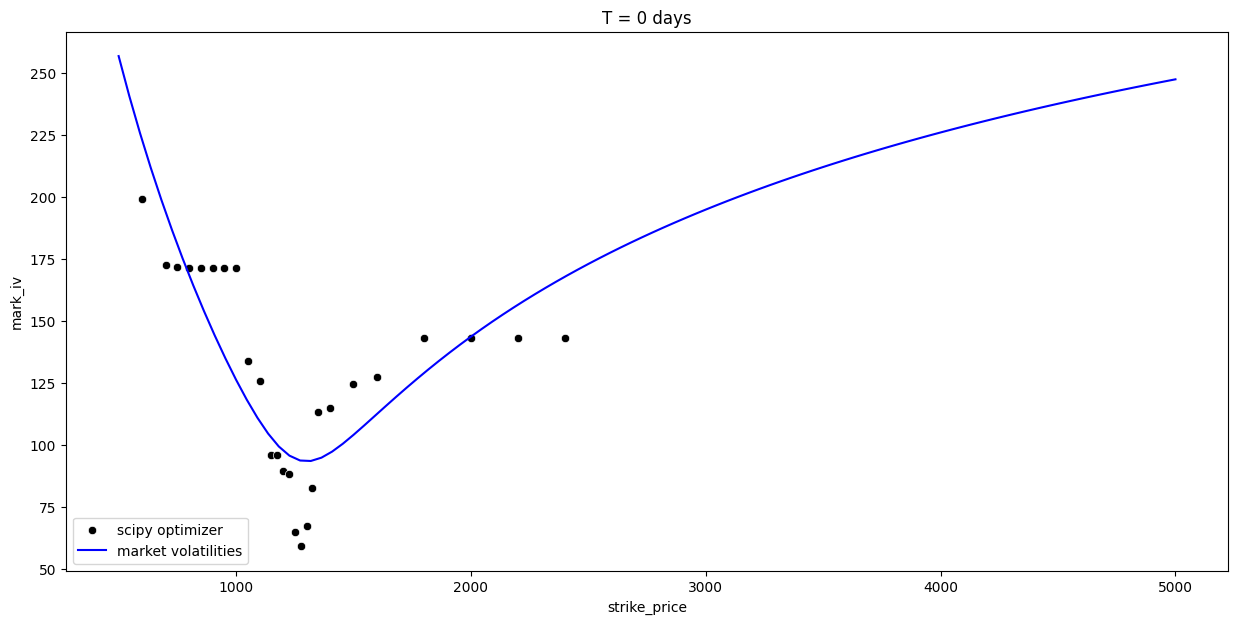

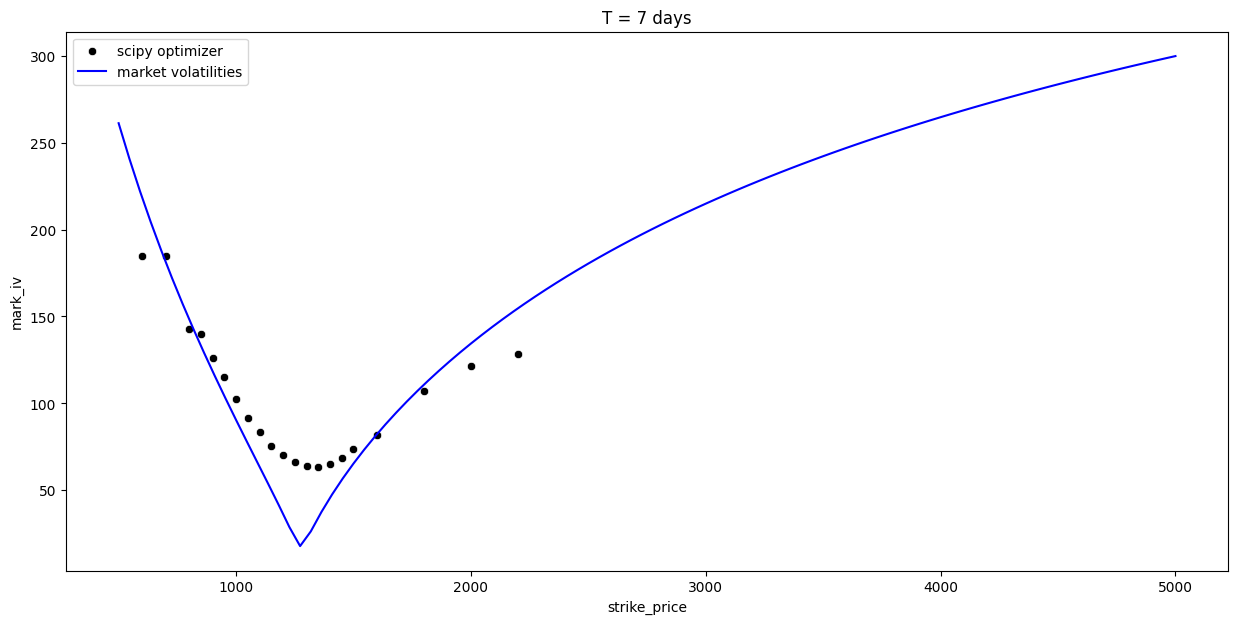

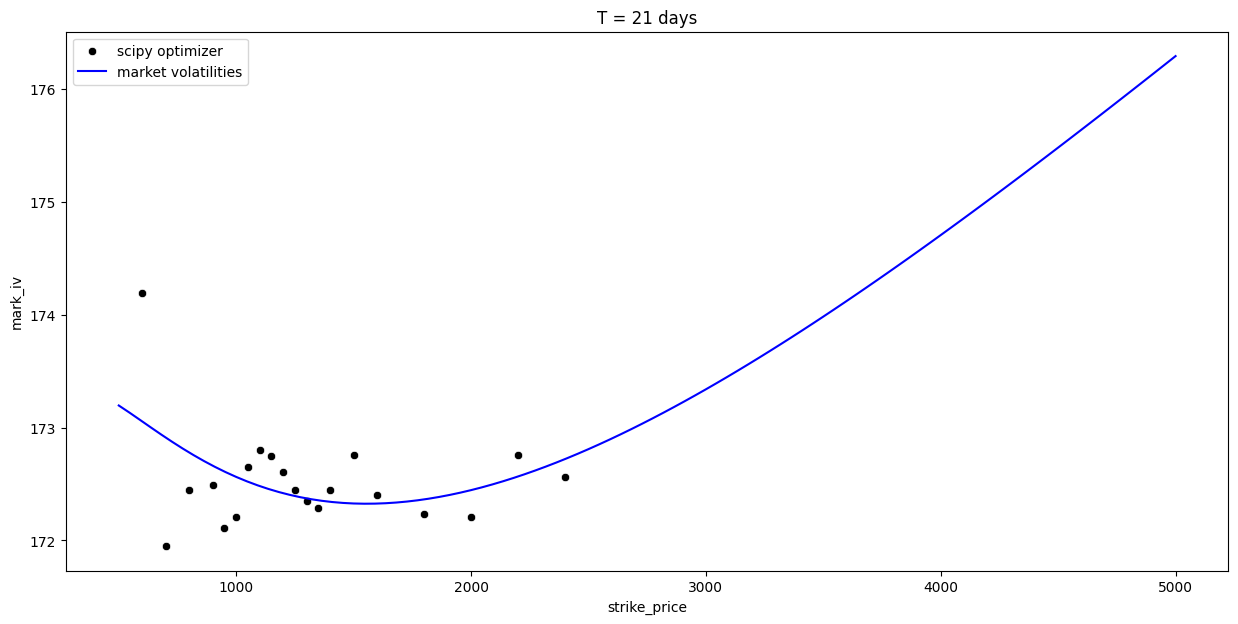

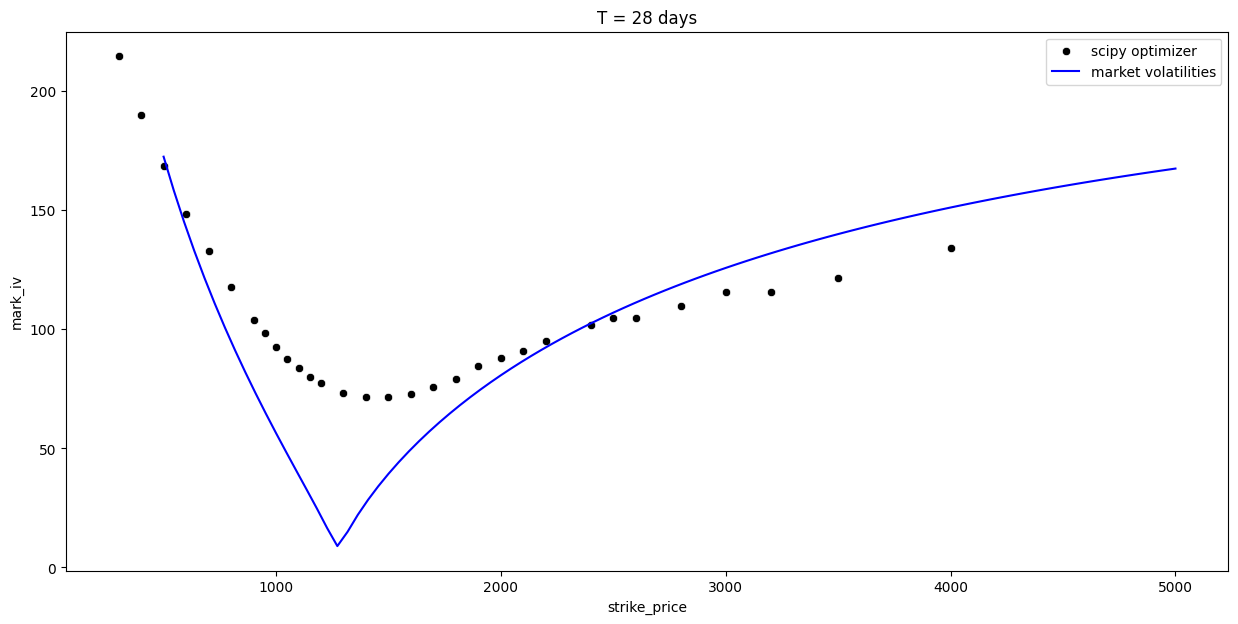

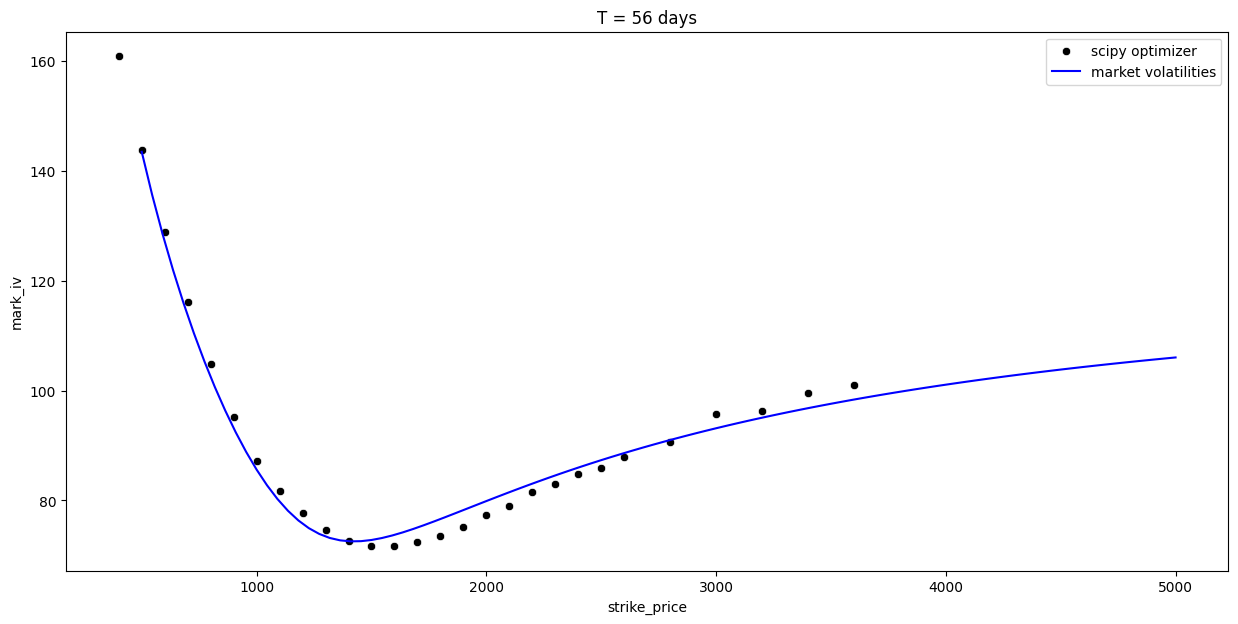

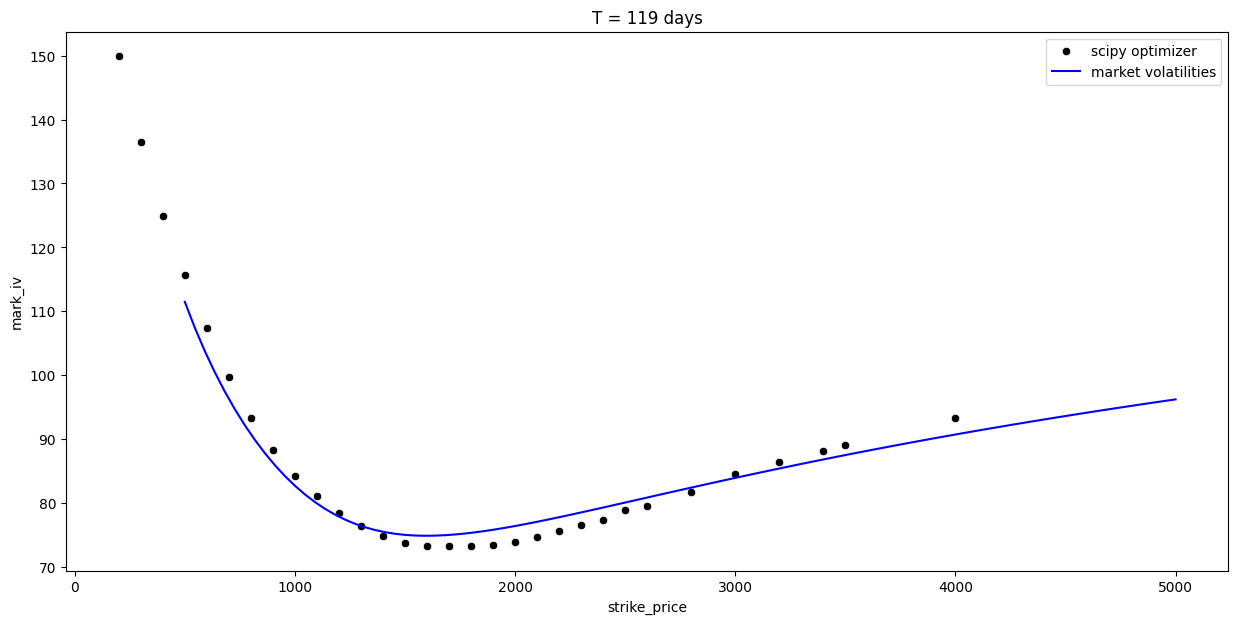

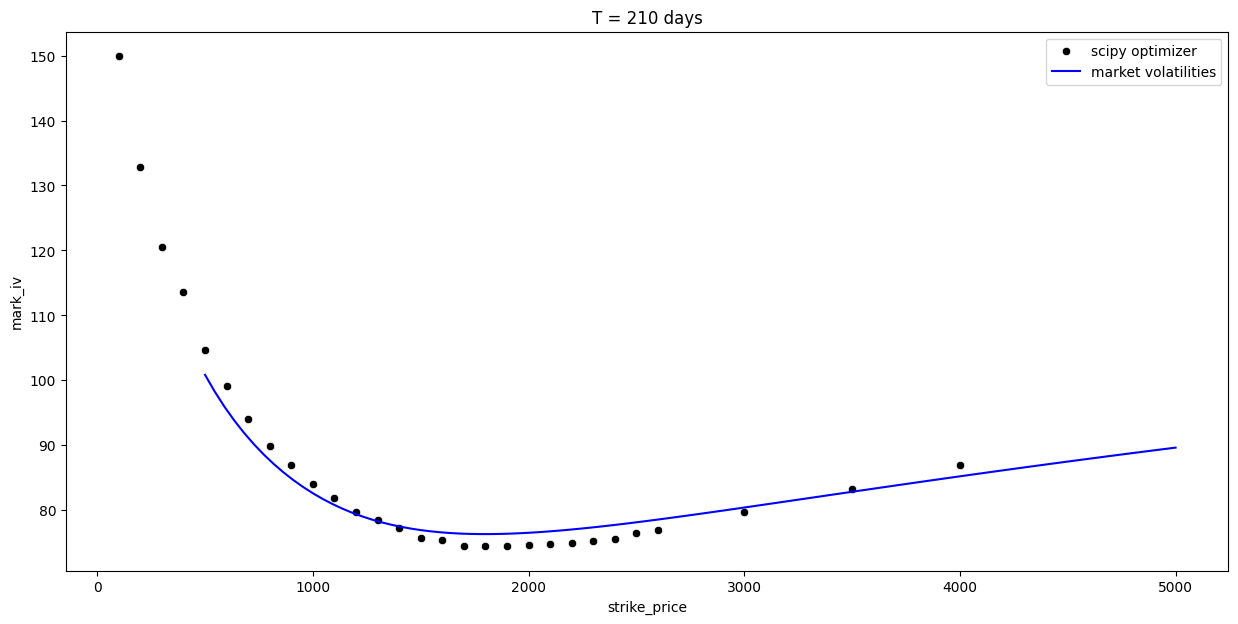

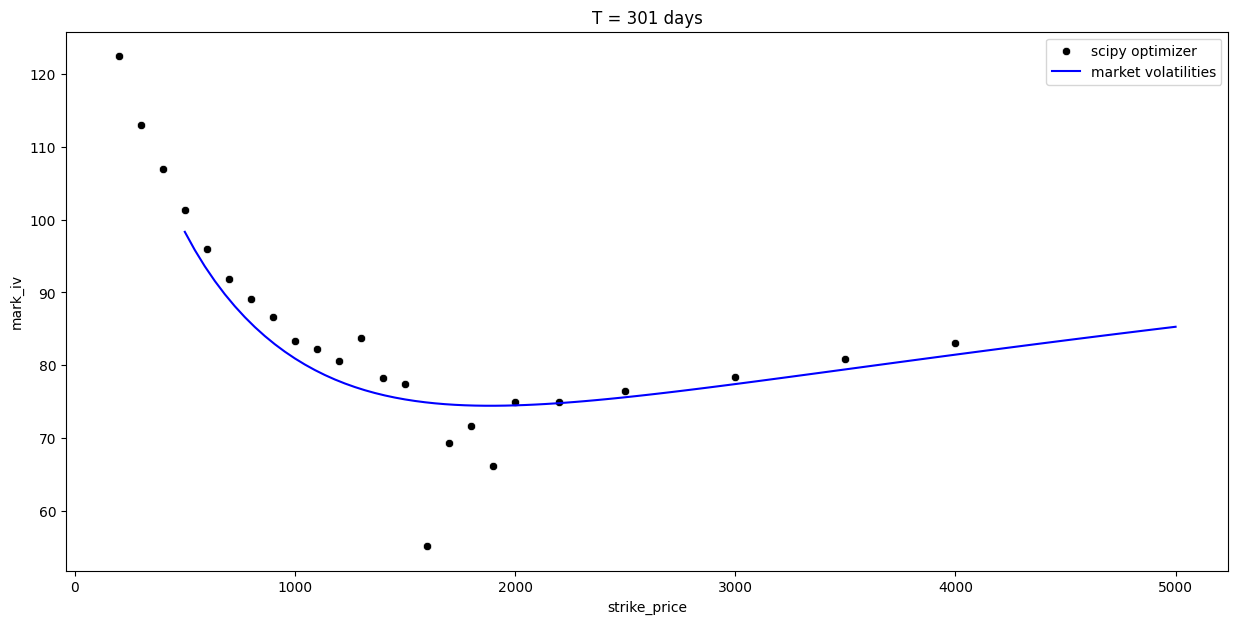

In [62]:
# выкидываем из выборки опционы, которые deep ITM
list_of_vols = []
for day in days:
    call_ = call[call.days == day]
    put_ = put[put.days == day]
    
    cc = call_[call_["strike_price"]<=call_["underlying_price"]]
    pp = put_[put_["strike_price"]>=put_["underlying_price"]]
    dff = pd.concat([cc, pp])
    dff = dff[dff["strike_price"]<=4_000]
    
    sabr = SABR(dff)
    vols = sabr.run()
    list_of_vols.append(vols)

In [64]:
x, y, z = np.linspace(500, 5000, 100), days, np.array(list_of_vols)
sh_0, sh_1 = z.shape
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), 
                 )

fig.update_layout(title='Volatility surface', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene=dict(
        xaxis_title='Strike, $',
        yaxis_title='Maturite, days',
        zaxis_title='Volatility',
    )
                  
                 )
fig.show()